In [11]:
import sqlutilpy as sqlutil
import numpy as np
from idlplotInd import tvhist2d, oplot
import matplotlib.pyplot as plt
import dustmaps.sfd as SFD
plt.rcParams['figure.figsize'] = [10, 7]
betw= lambda x,x1,x2:(x>=x1)&(x<x2)

In [2]:
%matplotlib inline

In [3]:
wsdb_host = open('/home/skoposov/WSDB_host').readline().rstrip()
rad = 15
area = np.pi * rad**2
X = sqlutil.get(
    ''' select ra,dec,flux_g,flux_r,flux_z,flux_w1,flux_ivar_w1,flux_w2,pmra,pmdec,
        pmra_ivar,pmdec_ivar,parallax,parallax_ivar,gaia_phot_g_mean_mag from decals_dr8.main 
        where q3c_radial_query(ra,dec,180,20,%d) and type='PSF' and brick_primary;'''
    % (rad),
    asDict=True,
    host=wsdb_host)

In [4]:
g, r, z, w1, w2 = [
    22.5 - 2.5 * np.log10(X['flux_' + _]) for _ in ['g', 'r', 'z', 'w1', 'w2']
]
w1_faint = 22.5 - 2.5*np.log10(np.maximum(X['flux_w1'] - 3/np.sqrt(X['flux_ivar_w1']),1e-100)) 
# three sigma uppper limit on w1
ebv = SFD.SFDQuery().query_equ(X['ra'], X['dec'])
eg, er, ez, ew1, ew2 = [ebv * _ for _ in [3.237, 2.176, 1.217, .19, .15]]
plx, eplx = X['parallax'], 1. / X['parallax_ivar']**.5
pmra, pmdec = X['pmra'], X['pmdec']
epmra, epmdec = 1. / X['pmra_ivar']**.5, 1. / X['pmdec_ivar']**.5
gaia_G = X['gaia_phot_g_mean_mag']

/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [5]:
# Selection by parallax that should be robust to systematics and complete
plxsel = plx < (0.1 + 3 * eplx)

bhbdist = 10**((g - eg - 0.5) / 5. - 2
               )  # approximate distance to a star assuming it is a bhb

maxvel = 1000
bhbpmsel = np.sqrt(pmra**2 + pmdec**2) < (maxvel / bhbdist / 4.74 +
                                          2 * np.sqrt(epmra**2 + epmdec**2))
# stars having a velocity consistent within 3sigma of 1000 km/s

ingaiasel = gaia_G > 10
# ensure detection in Gaia

# = (~np.isfinite(w1))|((r-w1-er+ew1)<-1)
wisesel = ((r - er - 2.3 * (g - r - eg + er)) - (w1_faint - ew1)) < -1.5
# WISE selection reject things with with r-w1>-1.5

bhb_poly = lambda xgrid: 1.07163 * xgrid**5 - 1.42272 * xgrid**4 + 0.69476 * xgrid**3 - 0.12911 * xgrid**2 + 0.66993 * xgrid - 0.11368
#polynomial from Li, Koposov+2019
mincol = -0.35
maxcol = -0.02
grcolsel = betw(g - r - eg + er, mincol, maxcol)
rzcolsel = betw(r - z - er + ez - bhb_poly(g - r - eg + er), -0.1, 0.05)
grzcolsel = grcolsel & rzcolsel
xgrid = np.linspace(mincol, maxcol, 100)

/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in subtract
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encoun

/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


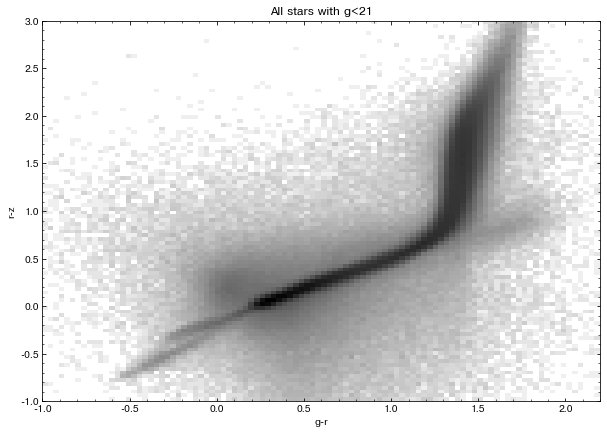

In [12]:
# All stars with g<21
tvhist2d(g - r - eg + er,
         r - z - er + ez,
         -1,
         2.2,
         -1,
         3,
         ind=(r < 21),
         zlog=True,
         xtitle='g-r',
         ytitle='r-z',
         title='All stars with g<21')

/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


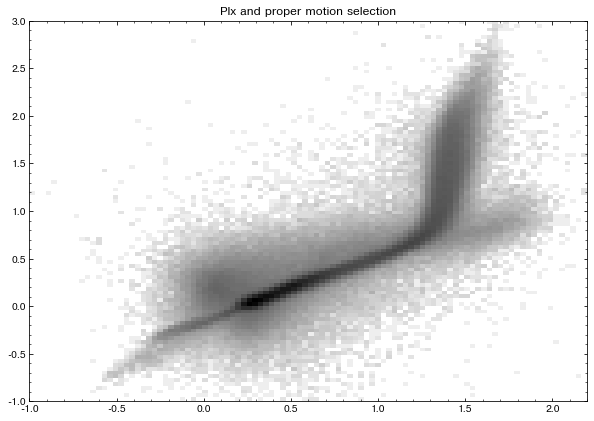

In [13]:
tvhist2d(g - r -eg +er,
         r - z -er +ez,
         -1,
         2.2,
         -1,
         3,
         ind=(r < 21) & bhbpmsel & plxsel,
         zlog=True,
         title='Plx and proper motion selection')

/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


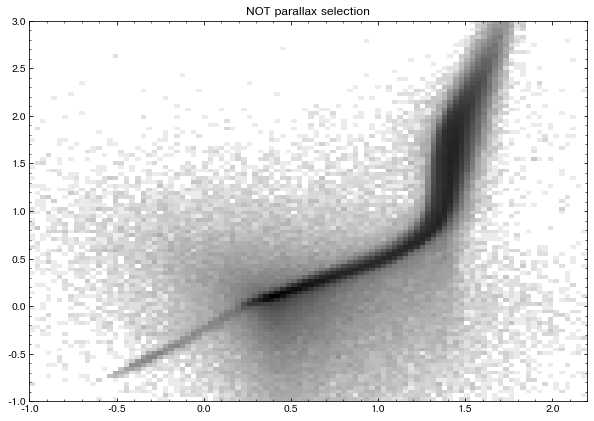

In [14]:
tvhist2d(g - r - eg + er,
         r - z - er + ez,
         -1,
         2.2,
         -1,
         3,
         ind=(r < 21) & (~plxsel),
         zlog=True,
         title='NOT parallax selection')

/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


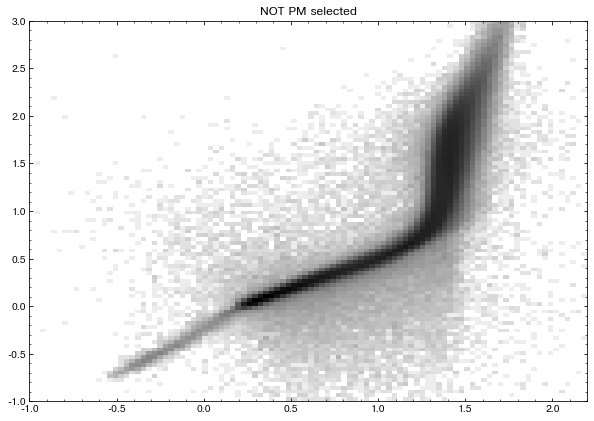

In [15]:
tvhist2d(g - r - eg + er,
         r - z - er + ez,
         -1,
         2.2,
         -1,
         3,
         ind=(r < 21) & (~bhbpmsel),
         zlog=True,
         title='NOT PM selected')

/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


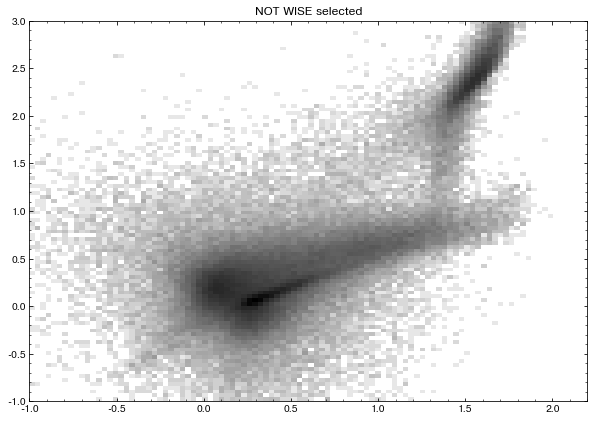

In [30]:
tvhist2d(g - r - eg + er,
         r - z - er + ez,
         -1,
         2.2,
         -1,
         3,
         ind=(r<21) & (~wisesel),
         zlog=True,
         title='NOT WISE selected')

/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


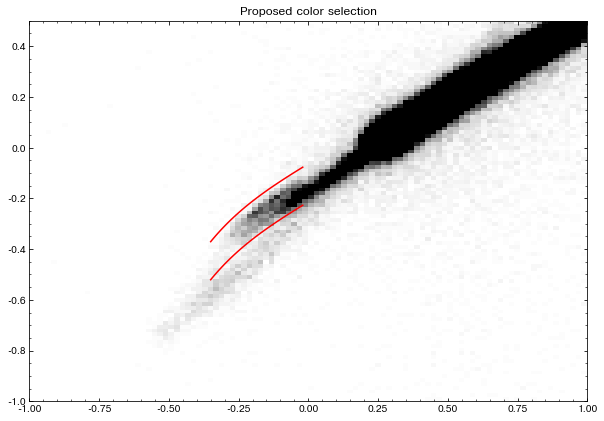

In [17]:
tvhist2d(g - r - eg + er,
         r - z - er + ez,
         -1,
         1,
         -1,
         .5,
         ind= (r < 21) & plxsel & (wisesel) & ingaiasel,
         vmaxfrac=.95,
         title='Proposed color selection',
         bins=[100, 100])
oplot(xgrid, bhb_poly(xgrid) - .1, color='red')
oplot(xgrid, bhb_poly(xgrid) + .05, color='red')

(0, 1.2732395447351628)

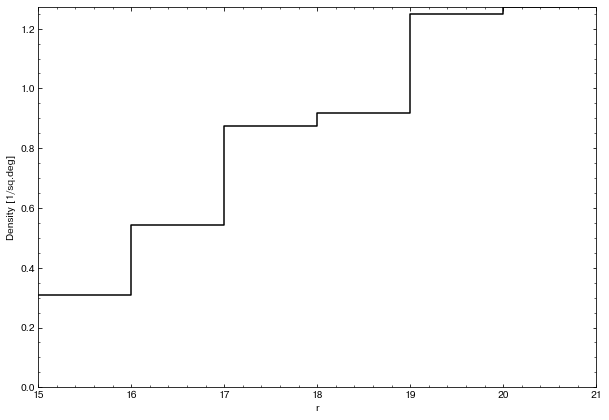

In [27]:
mainsel = plxsel & ingaiasel & grzcolsel & wisesel 

plothist(r, ind=mainsel,min=15,max=21,bin=1,weights=1./area,ytitle='Density [1/sq.deg]',xtitle='r'
        )
plt.ylim(0,plt.ylim()[1])

In [25]:
xra, xdec, xg, xr, xz, xw1, xw2 = sqlutil.get('''
with x as (select ra,dec from sdssdr9.specphotoall  as sp, sdssdr9.sppparams as spp 
where sp.specobjid=spp.specobjid and loggadop between 2 and 3.5 and elodiervfinal between -500 and 500 and 
sp.scienceprimary=1 
and teffadop>7200
order by q3c_ang2ipix(ra,dec)) select x.ra,x.dec,flux_g,flux_r,flux_z,flux_w1,flux_w2 from x, decals_dr8.main as d where 
q3c_join(x.ra,x.dec,d.ra,d.dec,1./3600);
''',
                                              host=wsdb_host)
xebv = SFD.SFDQuery().query_equ(xra, xdec)
xg, xr, xz = [22.5 - 2.5 * np.log10(_) for _ in [xg, xr, xz]]
xeg, xer, xez, xew1, xew2 = [xebv * _ for _ in [3.237, 2.176, 1.217, .19, .15]]

/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


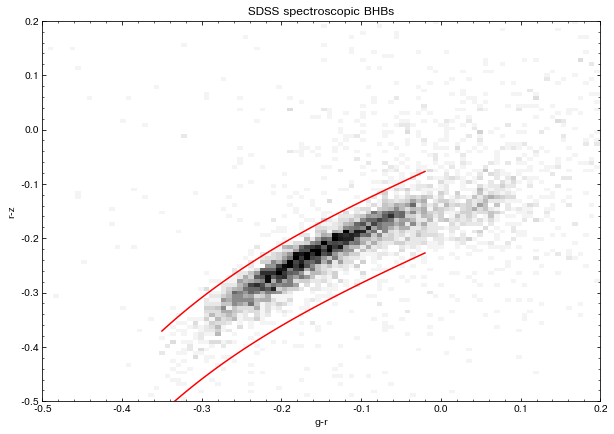

In [29]:
tvhist2d(xg - xr - xeg + xer,
         xr - xz - xer + xez,
         -0.5,
         0.2,
         -0.5,
         0.2,
         vmaxfrac=.999,
         title='SDSS spectroscopic BHBs',
         xtitle='g-r',
         ytitle='r-z')
oplot(xgrid, bhb_poly(xgrid) + 0.05, color='red')
oplot(xgrid, bhb_poly(xgrid) - 0.1, color='red')